In [1]:
import itertools
import json
import pennylane as qml
import pennylane.numpy as np    
import matplotlib.pyplot as plt

In [42]:
qubits = 9
strings = []
how_many = 0
for i in range((qubits-1)**2):
    strings.append(np.array([int(i) for i in f"{i:0{qubits-1}b}"]))
two_bits = np.zeros((qubits-1)**2)
for i, val in enumerate(strings):
    if np.sum(val)==2:
        how_many+=1
        two_bits[i]=1
two_bits=np.array(two_bits)
two_bits = two_bits/(np.linalg.norm(two_bits)**2)
# two_bits # statevector to put into qml.QubitStateVector 

In [33]:
def diffusion_operator(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)
        qml.PauliX(wires=wire)
    qml.ctrl(qml.PauliZ, [0,1,2,3,4,5,6,7])(wires=8)
    for wire in wires:
        qml.PauliX(wires=wire)
        qml.Hadamard(wires=wire)

In [38]:
def circuit(oracle):
    """
    Circuit whose output will determine the team that will carry out the project.

    Args:
        - oracle (callable): the oracle to use in the circuit. To use it, you can write ``oracle(wires = <wires>))``

    You do not have to return anything, just write the gates you need.
    """
    wires=[0,1,2,3,4,5,6,7,8]
    qml.QubitStateVector(two_bits,wires=[7,6,5,4,3,2,1,0])
    # for i in range(int(np.sqrt(how_many))):
    #     oracle(wires=wires)
    #     diffusion_operator(wires)


In [39]:
workers = [0, 1]
def oracle(wires):

    class op(qml.operation.Operation):
        num_wires = 9
        grad_method = None

        def __init__(self, wires, id=None):
            super().__init__(wires=wires, id=id)

        @property
        def num_params(self):
            return 0

        @staticmethod
        def compute_decomposition(wires):
            n_workers = 8
            matrix = np.eye(2 ** n_workers)

            for x in range(2 ** n_workers):
                bit_strings = np.array([int(i) for i in f"{x:0{n_workers}b}"])
                if sum(bit_strings[workers]) > 1:
                    matrix[x, x] = -1
            ops = []
            ops.append(qml.Hadamard(wires=wires[-1]))
            ops.append(qml.ctrl(qml.QubitUnitary(matrix, wires=wires[:-1]), control=wires[-1]))
            ops.append(qml.Hadamard(wires=wires[-1]))

            return ops

    return op(wires=wires)
dev = qml.device("default.qubit", wires=9)
@qml.qnode(dev)
def circuit_solution():
    circ = circuit(oracle)
    return qml.probs(wires = range(8))
sol = circuit_solution()


In [40]:
sol

tensor([0.        , 0.        , 0.        , 0.03571429, 0.        ,
        0.03571429, 0.03571429, 0.        , 0.        , 0.03571429,
        0.03571429, 0.        , 0.03571429, 0.        , 0.        ,
        0.        , 0.        , 0.03571429, 0.03571429, 0.        ,
        0.03571429, 0.        , 0.        , 0.        , 0.03571429,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.03571429, 0.03571429,
        0.        , 0.03571429, 0.        , 0.        , 0.        ,
        0.03571429, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.03571429, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03571429, 0.03571429, 0.        , 0.03571429, 0.        ,
        0.        , 0.        , 0.03571429, 0.  

<BarContainer object of 256 artists>

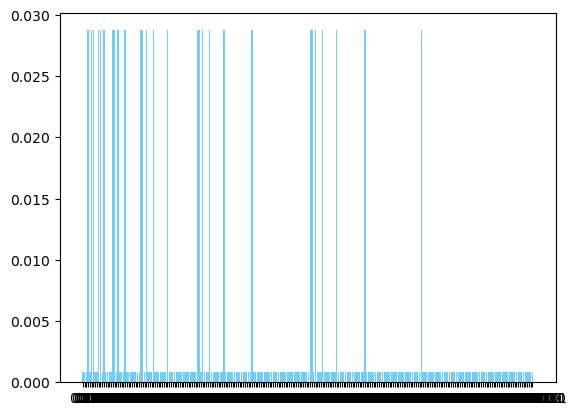

In [37]:
bit_strings = [f"{x:0{3}b}" for x in range(len(sol))]

plt.bar(bit_strings, sol, color = "#70CEFF")


In [16]:
# 
# plt.imshow(np.array(mat_storage))
# n_workers = 8
# matrix = np.eye(2 ** n_workers)

# for x in range(2 ** n_workers):
#     bit_strings = np.array([int(i) for i in f"{x:0{n_workers}b}"])
#     if sum(bit_strings[workers]) > 1:
#         matrix[x, x] = -1
# # plt.matshow(matrix)
print(qml.draw(circuit_solution,expansion_strategy='device')())

NameError: name 'cf' is not defined

In [79]:
def run(case: str) -> str:
    workers = json.loads(case)

    def oracle_maker():
        """
        This function will create the Project oracle of the statement from the list of non-lazy workers.

        Returns:
            callable: the oracle function
        """

        def oracle(wires):

            class op(qml.operation.Operation):
                num_wires = 9
                grad_method = None

                def __init__(self, wires, id=None):
                    super().__init__(wires=wires, id=id)

                @property
                def num_params(self):
                    return 0

                @staticmethod
                def compute_decomposition(wires):
                    n_workers = 8
                    matrix = np.eye(2 ** n_workers)

                    for x in range(2 ** n_workers):
                        bit_strings = np.array([int(i) for i in f"{x:0{n_workers}b}"])
                        if sum(bit_strings[workers]) > 1:
                            matrix[x, x] = -1

                    ops = []
                    ops.append(qml.Hadamard(wires=wires[-1]))
                    ops.append(qml.ctrl(qml.QubitUnitary(matrix, wires=wires[:-1]), control=wires[-1]))
                    ops.append(qml.Hadamard(wires=wires[-1]))

                    return ops

            return op(wires=wires)

        return oracle

    dev = qml.device("default.qubit", wires=9)
    oracle = oracle_maker()
    @qml.qnode(dev)
    def circuit_solution(oracle):
        circuit(oracle)
        return qml.probs(wires = range(8))

    return json.dumps([float(i) for i in circuit_solution(oracle)] + workers)


def check(have: str, want: str) -> None:
    have = json.loads(have)
    probs = have[:2**8]
    workers = have[2**8:]
    sol = 0
    n_workers = 8
    for x in range(2 ** n_workers):
        bit_strings = np.array([int(i) for i in f"{x:0{n_workers}b}"])
        if sum(bit_strings[workers]) == 2:
            num_dec = int(''.join(map(str, bit_strings)), 2)
            sol += probs[num_dec]

    assert sol >= 0.95, "The probability success is less than 0.95"


# These are the public test cases
test_cases = [
    ('[0, 1, 3, 6]', 'No output'),
    ('[1,7]', 'No output'),
    ('[0, 1, 2, 3, 4, 5, 6, 7]', 'No output')
]

# This will run the public test cases locally
for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        print(output,expected_output)
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")

Running test case 0 with input '[0, 1, 3, 6]'...
[0.57031249999997, 0.0, 0.07031249999999617, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07031249999999634, 0.0, 0.007812499999999607, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07031249999999639, 0.0, 0.007812499999999604, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007812499999999603, 0.0, 0.007812499999999614, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07031249999999631, 0.0, 0.0078124999999995915, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007812499999999606, 0.0, 0.007812499999999621, 0.0, 0.0, 0.0, 0.0

AssertionError: The probability success is less than 0.95

In [31]:
def _w_state_circuit(nn, mm, qubitC):    
    global qubitT #reference to global variable qubitT
    
    if nn == 0 and mm == 1:
        pass #do nothing in this case
    elif nn == 1 and mm == 2: #case (1,2)
        
        qml.ctrl(qml.U3,qubitC)(np.pi/2,0,0,qubitT)
        qml.CNOT([qubitT, qubitC])
        qubitT = qubitT + 1
    else: #otherwise
        theta = 2*np.arccos(np.sqrt(nn/mm))
        qml.ctrl(qml.U3,qubitC)(theta,0,0,qubitT)
        qml.CNOT([qubitT, qubitC])
        
        qubitTRecurse = qubitT #saving target qubit index, used as control qubit for lower child
        qubitT = qubitT + 1
        
        a = np.floor(nn/2)
        b = np.floor(mm/2)
        c = np.ceil(nn/2)
        d = np.ceil(mm/2)
        
        if a == 1 and b == 1: #upper child (1,1) => (1,2) became upper child
            _w_state_circuit(1, 2, qubitC)
            #there is no lower child
        elif c == 1 and d == 1: #lower child (1,1) => (1,2) became lower child
            _w_state_circuit(1, 2, qubitTRecurse)
            #there is no upper child
        else:                       
            #upper child
            _w_state_circuit(a, b, qubitC)                 
            #lower child
            _w_state_circuit(c, d, qubitTRecurse)
        
def w_state_circuit (qubits):
    global qubitT
    qubitT = 1 #index of a qubit a new gate acts on (hard to compute inside recursion => global variable)
    qml.PauliX(0)
    _w_state_circuit(np.floor(qubits/2), qubits, 0)



In [32]:
# Generate 2 qubit superposition
def f(theta: float):
    """Add Controlled-F gate to quantum circuit

    Args:
        - qc (qiskit.QuantumCircuit): ddded circuit
        - theta (float): arccos(1/sqrt(num_qubits), base on number of qubit
        - qubit1 (int): control qubit
        - qubit2 (int): target qubit

    Returns:
        - qiskit.QuantumCircuit: Added circuit
    """
    u = np.array([[1, 0, 0, 0], [0, np.cos(theta), 0,
                                 np.sin(theta)], [0, 0, 1, 0],
                  [0, np.sin(theta), 0, -np.cos(theta)]])
    u = np.array([[np.cos(theta),np.sin(theta)],[np.sin(theta),-np.cos(theta)]])
    return u

def w3(qubit: int):
    """Create W state for 3 qubits

    Args:
        - circuit (qiskit.QuantumCircuit): added circuit
        - qubit (int): the index that w3 circuit acts on

    Returns:
        - qiskit.QuantumCircuit: added circuit
    """
    theta = np.arccos(1 / np.sqrt(3))
    qml.ctrl(qml.QubitUnitary,control=0)(f(theta),1)
    qml.ctrl(qml.PauliX,control=1)(0)
    qml.ctrl(qml.Hadamard, control=1)(2)
    qml.ctrl(qml.PauliX,control=2)(1)


def w(num_qubits: int, shift: int = 0,total_qubits=4):
    """The below codes is implemented from [this paper](https://arxiv.org/abs/1606.09290)
    \n Simplest case: 3 qubits. <img src='../images/general_w.png' width = 500px/>
    \n General case: more qubits. <img src='../images/general_w2.png' width = 500px/>

    Args:
        - num_qubits (int): number of qubits
        - shift (int, optional): begin wire. Defaults to 0.

    Raises:
        - ValueError: When the number of qubits is not valid

    Returns:
        - qiskit.QuantumCircuit
    """
    if num_qubits < 2:
        raise ValueError('W state must has at least 2-qubit')
    if num_qubits == 2:
        # |W> state ~ |+> state
        qml.Hadamard(0)
    if num_qubits == 3:
        # Return the base function
        w3(shift)
        return
    else:
        # Theta value of F gate base on the circuit that it acts on
        theta = np.arccos(1 / np.sqrt(total_qubits - shift))
        qml.ctrl(qml.QubitUnitary,control= shift)(f(theta),shift+1)
        # Recursion until the number of qubits equal 3
        w(num_qubits - 1, total_qubits - (num_qubits - 1),total_qubits=total_qubits)
        for i in range(1, num_qubits):
            qml.ctrl(qml.PauliX,control=[i + shift])(shift)
def w_circuit(num_qubits):
    qml.PauliX(0)
    w(num_qubits,0,num_qubits)